## All you need is love… And a pet!

<img src="img/dataset-cover.jpg" width="920">

Here we are going to build a classifier to predict whether an animal from an animal shelter will be adopted or not (aac_intakes_outcomes.csv, available at: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/version/1#aac_intakes_outcomes.csv). You will be working with the following features:

1. *animal_type:* Type of animal. May be one of 'cat', 'dog', 'bird', etc.
2. *intake_year:* Year of intake
3. *intake_condition:* The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.
4. *intake_number:* The intake number denoting the number of occurrences the animal has been brought into the shelter. Values higher than 1 indicate the animal has been taken into the shelter on more than one occasion.
5. *intake_type:* The type of intake, for example, 'stray', 'owner surrender', etc.
6. *sex_upon_intake:* The gender of the animal and if it has been spayed or neutered at the time of intake
7. *age_upon\_intake_(years):* The age of the animal upon intake represented in years
8. *time_in_shelter_days:* Numeric value denoting the number of days the animal remained at the shelter from intake to outcome.
9. *sex_upon_outcome:* The gender of the animal and if it has been spayed or neutered at time of outcome
10. *age_upon\_outcome_(years):* The age of the animal upon outcome represented in years
11. *outcome_type:* The outcome type. Can be one of ‘adopted’, ‘transferred’, etc.

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from itertools import combinations 
import ast
from sklearn.linear_model import LogisticRegression
import seaborn as sn
%matplotlib inline

data_folder = './data/'

### A) Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). 
- Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. 
- Standardize the values of each feature in the data to have mean 0 and variance 1.

The use of external libraries is not permitted in part A, except for numpy and pandas. 
You can drop entries with missing values.

In [5]:
columns = ['animal_type', 'intake_year', 'intake_condition', 'intake_number', 'intake_type', 'sex_upon_intake', \
          'age_upon_intake_(years)', 'time_in_shelter_days', 'sex_upon_outcome', 'age_upon_outcome_(years)', \
          'outcome_type']
original_data = pd.read_csv(data_folder+'aac_intakes_outcomes.csv', usecols=columns)
original_data.head()

,outcome_type,sex_upon_outcome,age_upon_outcome_(years),animal_type,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days
0,Return to Owner,Neutered Male,10.0,Dog,Normal,Stray,Neutered Male,10.0,2017,1.0,0.588194
1,Return to Owner,Neutered Male,7.0,Dog,Normal,Public Assist,Neutered Male,7.0,2014,2.0,1.259722
2,Return to Owner,Neutered Male,6.0,Dog,Normal,Public Assist,Neutered Male,6.0,2014,3.0,1.113889
3,Transfer,Neutered Male,10.0,Dog,Normal,Owner Surrender,Neutered Male,10.0,2014,1.0,4.970139
4,Return to Owner,Neutered Male,16.0,Dog,Injured,Public Assist,Neutered Male,16.0,2013,1.0,0.119444


In [42]:
def split(data, ratio= 0.8):
    mask = np.random.rand(len(data)) < ratio
    training = data[mask]
    test = data[mask == False]
    return training, test

In [55]:
copy_data = original_data.copy() #deep copy
copy_data['adopted'] = copy_data.outcome_type.apply(lambda r: 1 if r=='Adoption' else 0)
copy_data.drop("outcome_type", axis = 1, inplace=True)


In [56]:
training, test = split(copy_data)
print(training.shape[0] / copy_data.shape[0])
print(test.shape[0] / copy_data.shape[0])

0.8028793051511196
0.19712069484888042


In [64]:
non_number_column = ["sex_upon_outcome", "animal_type", "intake_condition", "intake_type", "sex_upon_intake"]
train_cat = pd.get_dummies(training, columns = non_number_column)

In [67]:
test_cat = pd.get_dummies(test, columns = non_number_column)[train_cat.columns]

In [71]:
train_label = train_cat.adopted
train_features = train_cat.drop("adopted", axis = 1)

test_label = test_cat.adopted
test_features = test_cat.drop("adopted", axis = 1)


In [81]:
means = train_features.mean()
stds = train_features.std()
train_features_std = pd.DataFrame()
for c in train_features.columns:
    train_features_std[c] = (train_features[c]-means[c])/stds[c]

# Use the mean and stddev of the training set
test_features_std = pd.DataFrame()
for c in test_features.columns:
    test_features_std[c] = (test_features[c]-means[c])/stds[c]


### B) Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. 
- For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. 

In [151]:
def confusion_matrix(true_label, prediction_proba, threshold):
    guess_values = (prediction_proba[:,1]>threshold)
    true_positive = np.sum(np.logical_and(guess_values==1, true_label==1))
    false_positive = np.sum(np.logical_and(guess_values==1, true_label==0))
    true_negative = np.sum(np.logical_and(guess_values==0, true_label==0))
    false_negative = np.sum(np.logical_and(guess_values==0, true_label==1))

    confusion_matrix = np.asarray([[true_positive, false_positive],
                                    [false_negative, true_negative]])
    return confusion_matrix

def plot_confusion_matrix(confusion_matrix):
    [[TP, FP], [FN, TN]] = confusion_matrix
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]])
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) 
    
    return sn.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')

def get_perf(confusion_matrix):
    [[TP, FP], [FN, TN]] = confusion_matrix
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * precision * recall / (precision + recall)
    return [accuracy, precision, recall, f1_score]
    



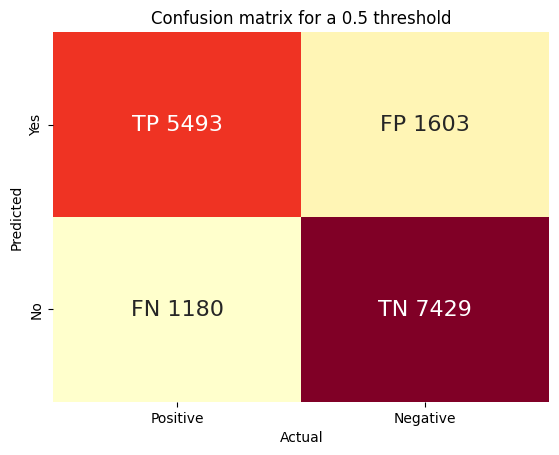

In [152]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic.fit(train_features_std, train_label)
prediction_proba = logistic.predict_proba(test_features_std)
confusion_matrix_05 = confusion_matrix(test_label, prediction_proba, 0.5)
ax = plot_confusion_matrix(confusion_matrix_05)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for a 0.5 threshold')
plt.show()

In [154]:
accuracy, precision, recall, f1_score = get_perf(confusion_matrix_05)

print("accuracy : " + str(accuracy))
print("precision : " + str(precision))
print("recall : " + str(recall))
print("f1_score : " + str(f1_score))

accuracy : 0.8227952881248011
precision : 0.7740980834272829
recall : 0.8231679904091114
f1_score : 0.7978792940663809


### C) Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold.

/var/folders/lx/78bdvyf1797_dxpw5r160s9c0000gn/T/ipykernel_71267/2226500006.py:24: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)


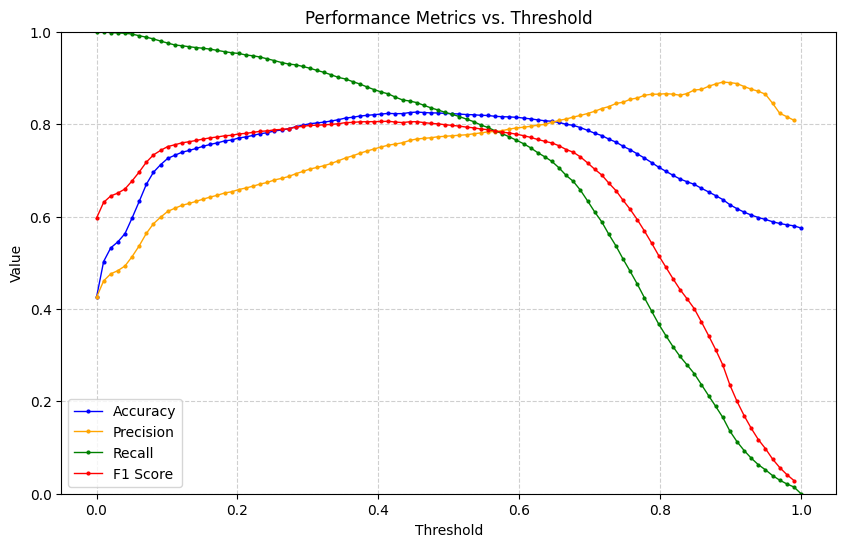

In [167]:
th = np.linspace(0,1,100)
accuracies = np.empty(100)
precisions = np.empty(100)
recalls = np.empty(100)
f1_scores = np.empty(100)
count = 0
for i in th:
    cm = confusion_matrix(test_label, prediction_proba, i)
    accuracy, precision, recall, f1_score = get_perf(cm)
    accuracies[count] = accuracy
    precisions[count] = precision
    recalls[count] = recall
    f1_scores[count] = f1_score
    count+=1

    
# Plot the graph
plt.figure(figsize=(10, 6))

plt.plot(th, accuracies, label="Accuracy", color="blue", marker='o', markersize=2, linewidth=1)
plt.plot(th, precisions, label="Precision", color="orange", marker='o', markersize=2, linewidth=1)
plt.plot(th, recalls, label="Recall", color="green", marker='o', markersize=2, linewidth=1)
plt.plot(th, f1_scores, label="F1 Score", color="red", marker='o', markersize=2, linewidth=1)

# Customize the plot
plt.title("Performance Metrics vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Value")
plt.ylim(0, 1)  # Since the values are typically between 0 and 1
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()
    

### D) Plot in a bar chart the coefficients of the logistic regression sorted by their contribution to the prediction.

In [169]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic.fit(train_features_std, train_label)
tmp = []
for name, value in zip(train_features_std.columns, logistic.coef_[0]):
    tmp.append({"name": name, "value": value})
    
features_coef = pd.DataFrame(tmp).sort_values("value")
features_coef.head()

,name,value
1,age_upon_intake_(years),-1.494077
6,sex_upon_outcome_Intact Male,-0.777823
5,sex_upon_outcome_Intact Female,-0.685816
26,intake_type_Wildlife,-0.615889
31,sex_upon_intake_Unknown,-0.479553


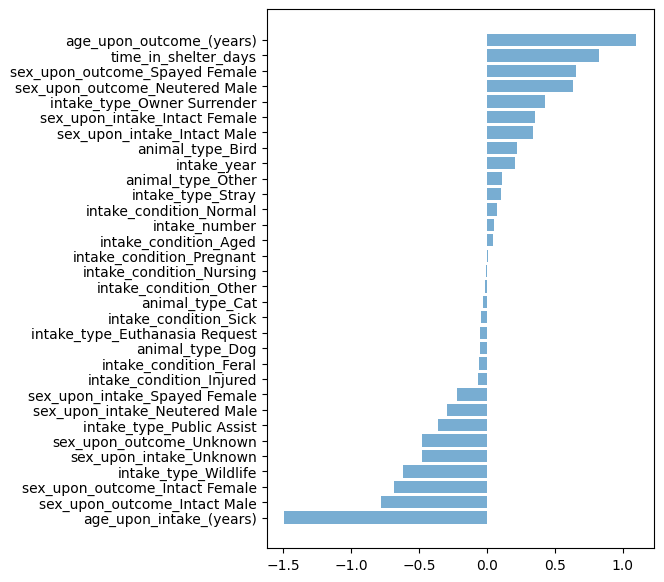

In [172]:
plt.subplots(figsize=(5,7))
plt.barh(features_coef.name, features_coef.value, alpha=0.6)
plt.show()


## Question 1: Which of the following metrics is most suitable when you are dealing with unbalanced classes?

- a) F1 Score
- b) Recall
- c) Precision
- d) Accuracy

In [174]:
# a

## Question 2: You are working on a binary classification problem. You trained a model on a training dataset and got the following confusion matrix on the test dataset. What is true about the evaluation metrics (rounded to the second decimal point):

|            | Pred = NO|Pred=YES|
|------------|----------|--------|
| Actual NO  |    50    |   10   |
| Actual YES |    5     |   100  |

- a) Accuracy is 0.95
- b) Accuracy is 0.85
- c) False positive rate is 0.95
- d) True positive rate is 0.95

In [ ]:
# d